In [2]:
from sklearn import tree, metrics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Data import and prep
sc_df = pd.read_csv('../../data/sc_decisions_final.csv')

# drop first col of indexes
sc_df = sc_df.iloc[: , 1:]

# fill missing values as they are legitimate
sc_df = sc_df.fillna("N/A")

# select explanatory and response variables
X = sc_df.loc[:, sc_df.columns != 'direction']
y = sc_df[['direction']].astype("category")

In [4]:
X.nunique() > 2

cat_vars = list(X.columns[X.nunique() > 2])
print(cat_vars)

bool_vars = list(X.columns[X.nunique() == 2])
print(bool_vars)

['c_lcDisagreement', 'c_lcDispositionDirection', 'c_issueArea', 'c_decisionTime', 'c_caseOriginRegion', 'c_caseOriginCourt', 'j_justiceRegion', 'j_justiceReligion', 'j_justiceEthnicity']
['c_chief', 'c_adminActionBool', 'c_oralArgBool', 'c_reargBool', 'c_formerCourt', 'e_houseMajority', 'e_senateMajority', 'e_decisionPresidentParty', 'e_JCApproval', 'j_justiceDecisionAgeBand', 'j_justicePresidentParty', 'j_justiceVotesAppointed']


In [5]:
# encode target
y = y.apply(lambda x: x.cat.codes)

# check encoding
# y.apply(lambda x: x.cat.categories) 

# Turn into dummy vars
X_cat = pd.get_dummies(X[cat_vars], columns = cat_vars)
X_bool = pd.get_dummies(X[bool_vars], columns = bool_vars, drop_first = True)

X_all = pd.concat([X_cat, X_bool], axis = 1)


# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_all , y, test_size = 0.25, random_state = 42)
print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (10535, 60)
Testing split input-  (3512, 60)


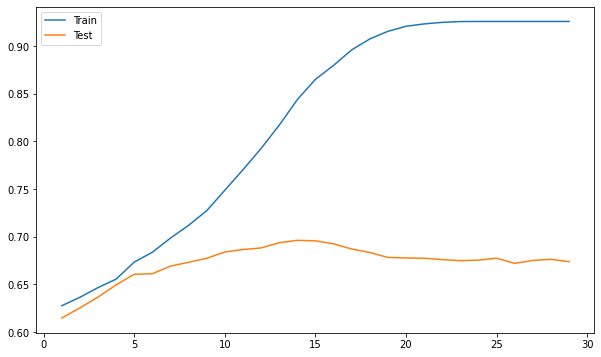

In [96]:
train_scores = []
test_scores = []

# tree depth
depths = [i for i in range(1, 30)]

# evaluate decision tree for each depth
for i in depths:
    model = RandomForestClassifier(
        n_estimators = 500,
        max_depth=i
    )
    model.fit(X_train, np.ravel(y_train))
    # evaluate train dataset
    yhat_train = model.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, yhat_train)
    train_scores.append(train_accuracy)
    
    # evaluate test dataset
    yhat_test = model.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, yhat_test)
    test_scores.append(test_accuracy)

# plot training and test results
plt.figure(figsize=(10,6)) 
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.legend()

In [6]:
train_scores = []
test_scores = []

# tree depth
n_trees = [100, 500, 1000, 2000, 5000]

# evaluate decision tree for each depth
for i in n_trees:
    print(i)
    model = RandomForestClassifier(
        n_estimators = i,
        max_depth=5
    )
    model.fit(X_train, np.ravel(y_train))
    # evaluate train dataset
    yhat_train = model.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, yhat_train)
    train_scores.append(train_accuracy)
    
    # evaluate test dataset
    yhat_test = model.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, yhat_test)
    test_scores.append(test_accuracy)

100
500
1000
2000
5000


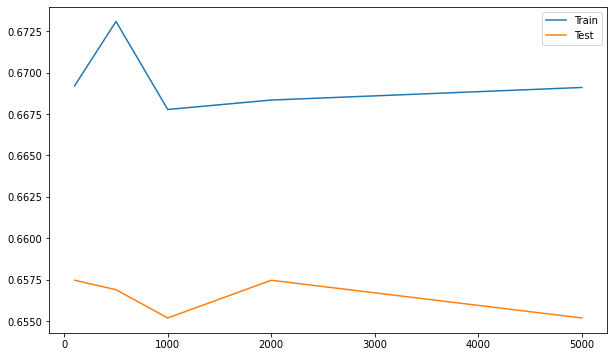

In [7]:
# plot training and test results
plt.figure(figsize=(10,6)) 
plt.plot(n_trees, train_scores, label='Train')
plt.plot(n_trees, test_scores, label='Test')
plt.legend()

In [26]:
forest = RandomForestClassifier(
    n_estimators = 150,
    max_depth = 5, 
    random_state = 0)
train_forest = forest.fit(X_train, np.ravel(y_train))

y_pred = train_forest.predict(X_test)
print(y_pred)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

[0 1 1 ... 0 0 1]
Accuracy: 0.6600227790432802


In [9]:
# Feature importances
feature_importances = train_forest.feature_importances_

# Feature labels
X_train.columns

pd.DataFrame(data = {
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values("importance", ascending = False).head(10)

,feature,importance
3,c_lcDispositionDirection_Conservative,0.212531
4,c_lcDispositionDirection_Liberal,0.189442
38,j_justiceReligion_Catholicism,0.106189
58,j_justicePresidentParty_Republican,0.070151
19,c_decisionTime_0-30 Days,0.033966
50,c_oralArgBool_1,0.026719
27,c_caseOriginRegion_West,0.024240
36,j_justiceRegion_South,0.023070
45,j_justiceEthnicity_African American,0.020540
44,j_justiceReligion_Protestant,0.020233


In [21]:

train_forest.estimators_.shape()

AttributeError: 'DecisionTreeClassifier' object has no attribute 'shape'

In [23]:
from sklearn.tree import export_graphviz
export_graphviz(train_forest.estimators_[0],
                feature_names=X_all.columns,
                filled=True,
                rounded=True)

'digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="c_lcDispositionDirection_Liberal <= 0.5\\ngini = 0.5\\nsamples = 6647\\nvalue = [5404, 5131]", fillcolor="#fef9f5"] ;\n1 [label="c_decisionTime_31-180 Days <= 0.5\\ngini = 0.471\\nsamples = 3229\\nvalue = [1962, 3197]", fillcolor="#b3d9f5"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="c_lcDisagreement_1.0 <= 0.5\\ngini = 0.44\\nsamples = 484\\nvalue = [253, 522]", fillcolor="#99ccf2"] ;\n1 -> 2 ;\n3 [label="j_justicePresidentParty_Republican <= 0.5\\ngini = 0.387\\nsamples = 347\\nvalue = [150, 422]", fillcolor="#7fc0ee"] ;\n2 -> 3 ;\n4 [label="c_oralArgBool_1 <= 0.5\\ngini = 0.286\\nsamples = 111\\nvalue = [33, 158]", fillcolor="#62b1ea"] ;\n3 -> 4 ;\n5 [label="gini = 0.064\\nsamples = 48\\nvalue = [3, 87]", fillcolor="#40a0e6"] ;\n4 -> 5 ;\n6 [label="gini = 0.418\\nsamples = 63\\nvalue = [30, 71]", fillcolor="#8dc6f

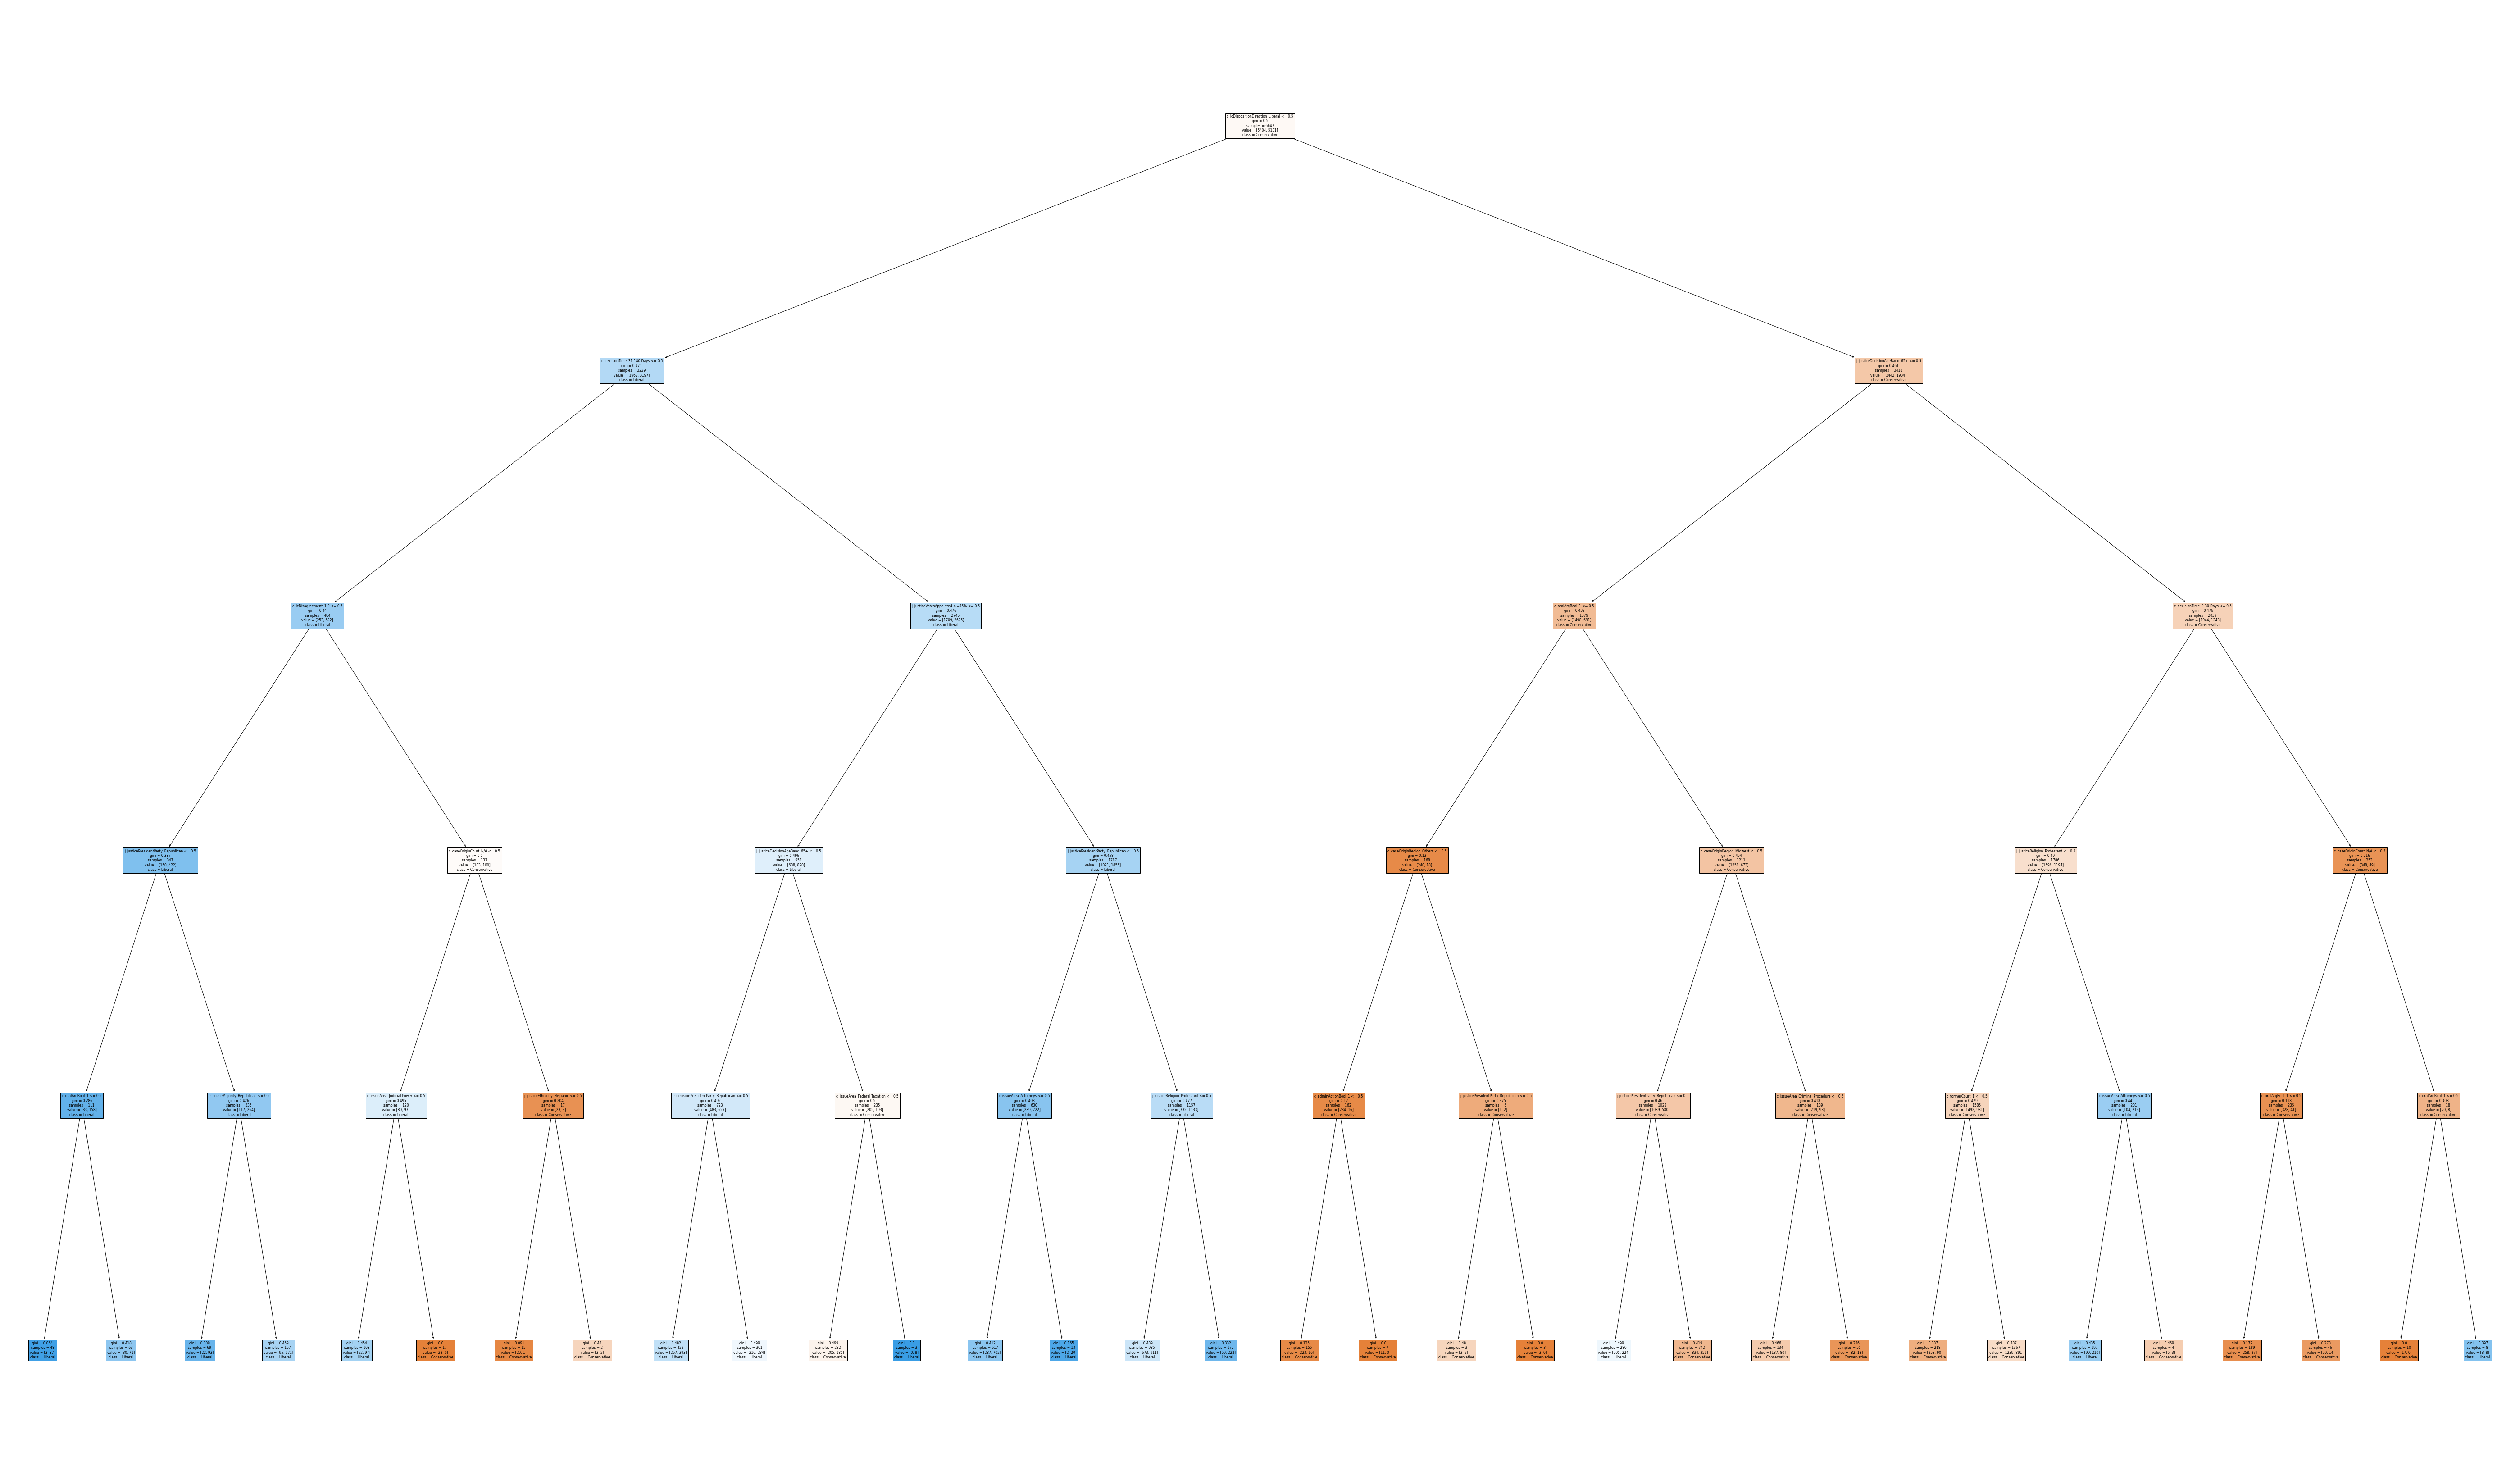

In [25]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
plt.figure(figsize=(100,60)) 
tree.plot_tree(train_forest.estimators_[0],
               feature_names = X_all.columns, 
               class_names = ["Conservative", "Liberal"],
               filled = True);
fig.savefig('rf_individualtree.png')